In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import regex as re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# TensorFlow and Keras

import tensorflow as tf
from tensorflow.keras import layers, models

# models

from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics 

## The ```imblearn``` Package

`imblearn` (short for "imbalanced-learn") is a Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It is part of the scikit-learn ecosystem and is built upon scikit-learn's pipelines and estimators.

Key features of `imblearn` include:

1. **Resampling Techniques**: Provides various methods to under-sample the majority class and over-sample the minority class. Examples include Random Over-Sampling, Random Under-Sampling, SMOTE (Synthetic Minority Over-sampling Technique), and ADASYN (Adaptive Synthetic Sampling).

2. **Integration with scikit-learn**: Designed to be compatible with scikit-learn, making it easy to integrate with scikit-learn workflows, including pipelines.

3. **Various Sampling Strategies**: Allows users to apply different resampling strategies to create balanced datasets, which is crucial for improving the performance of machine learning models on imbalanced datasets.

4. **Utility Functions**: Includes functions for evaluating classifier performance on imbalanced datasets, further aiding in model assessment and tuning.

Overall, `imblearn` is a valuable tool for machine learning practitioners dealing with imbalanced datasets, helping to improve model accuracy and robustness by addressing class imbalance issues.


# Data Download

To be able to run this notebooks you should download the data at this address (is a google drive zip file). Note that the file is ca. 500 Mb. You should unzip it in this folder. You should have a ```data``` folder in the same folder where  this notebook is.

You should download the data here: https://drive.google.com/file/d/13zcCbizuTFmU39uPKwNJ605JRz8i6uex/view?usp=sharing

## Data Description

Authors: Susanna Bisogni, Adriana Gargiulo.

This sample is composed of galaxies with redshifts between 0.05 and 0.06, selected using an SQL query from the Sloan Digital Sky Survey (SDSS) page at https://skyserver.sdss.org/dr16/en/tools/search/sql.aspx with the following query:


    SELECT TOP 11000 sp.plate, sp.fiberid, sp.mjd, sp.specObjID, sp.class, sp.ra, sp.dec, sp.z, sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z, gse.bptclass, gse.lgm_tot_p50, gse.lgm_fib_p50, gse.sfr_tot_p50, gse.sfr_fib_p50, gse.specsfr_tot_p50, gse.specsfr_fib_p50, gsl.oii_3726_eqw, gsl.oii_3726_eqw_err, gsl.oii_3726_flux, gsl.oii_3726_flux_err, gsl.oii_3729_eqw, gsl.oii_3729_eqw_err, gsl.oii_3729_flux, gsl.oii_3729_flux_err, gsl.h_beta_eqw, gsl.h_beta_eqw_err, gsl.h_beta_flux,  gsl.h_beta_flux_err, gsl.oiii_5007_eqw, gsl.oiii_5007_eqw_err, gsl.oiii_5007_flux, gsl.oiii_5007_flux_err, gsl.h_alpha_eqw, gsl.h_alpha_eqw_err,  gsl.h_alpha_flux,  gsl.h_alpha_flux_err, gsl.nii_6548_eqw,  gsl.nii_6548_eqw_err,  gsl.nii_6548_flux,  gsl.nii_6548_flux_err, gsl.nii_6584_eqw, gsl.nii_6584_eqw_err, gsl.nii_6584_flux, gsl.nii_6584_flux_err, gsi.d4000, gsi.d4000_err, gsi.d4000_n, gsi.d4000_n_err, gsinfo.spectrotype, gsinfo.subclass, gsinfo.v_disp, gsinfo.sn_median, gsinfo.e_bv_sfd
    FROM SpecPhoto as sp LEFT JOIN galSpecExtra as gse ON sp.specObjID=gse.specObjID LEFT JOIN galSpecLine as gsl ON gse.specObjID=gsl.specObjID LEFT JOIN galSpecIndx as gsi ON gsl.specObjID=gsi.specObjID LEFT JOIN galSpecInfo as gsinfo ON gsi.specObjID=gsinfo.specObjID 
    WHERE ((class='QSO' OR class='GALAXY' OR class='STAR') AND (sp.z BETWEEN 0.05 AND 0.06) AND zWarning=0)

We have retained a lot of information, in case it might be useful later. We will only use a small part of it for this application.
From the query's output table, we select objects based on the BPT classification described in Brinchmann et al. 2004.

In a first selection, a simple case, we consider only objects classified as:
 
- 1  STAR FORMING (SF)
- 3 COMPOSITE (C)
- 4 AGN
- -1. UNCLASSIFIABLE (which we have determined to coincide, through a check with Thomas+2010, with passive galaxies)

In a second, more complex selection, with data having worse signal-to-noise ratio (S/N), we consider only objects classified as:
5 LOW S/N AGN
2 LOW S/N SF

To verify the correctness of the passive classification, we cross-matched our sample with that of Thomas et al. 2010 (http://www.icg.port.ac.uk/~thomasd/moses.html). We then defined an elliptical_passive.fits table, containing sources identified as passive according to Brinchmann (bptclass=-1), and we generally retained the cross-match of Thomas with this portion of DR16 that we selected (the first 11000 entries, to be precise) to understand what sources are not classified as passive (bpt_brinchmann =-1) but are still elliptical, as identified in Thomas' sample (this table is match_thomas_subsampleDR16.fits). This table contains passive sources with bpt_brinchmann =-1, but also objects classified by Brinchmann as:

- 1 STAR FORMING (SF)
- 2 LOW S/N SF
- 3 COMPOSITE
- 4 AGN
- 5 LOW S/N AGN.

CAUTION: of the previous selection (SQL query and division of the sample into two subsamples), only the spectra with spectral channels between 3700 and 8600 Å, once brought to the rest frame, have been interpolated to this common grid with a step of delta_lambda=2Å. Others have been discarded.
The final sample is therefore composed of 8133 (sample1) + 2804 (sample2) = 10937 galaxies.


In [2]:
path = r'./data/sample1/GALAXY_z_0.05-0.06_SAMPLE1_ASCII/' # use your path
all_files = glob.glob(os.path.join(path , "*.txt"))

In [3]:
# Number of files in the folder
print(len(all_files))

8134


Now we need to get the classes from the file name, and that needs to be done with regular expressions (). We need to get the text between the last "." (the one before the file type) and the last underscore "_". For exampe we need to extract ```SF``` from the string (filename) ```./data/sample1/GALAXY_z_0.05-0.06_SAMPLE1_ASCII/spec-0714-52201-0149_SF.txt```.

In [4]:
print(all_files[0])
m = re.search(r"^.*_\K[^.]+", all_files[0])
m[0]

./data/sample1/GALAXY_z_0.05-0.06_SAMPLE1_ASCII/spec-0714-52201-0149_SF.txt


'SF'

After having a filename, we can open it in a pandas dataframe.

In [5]:
columns = ['lambda', 'flux', 'error']
df_tmp = pd.read_csv(all_files[0], skiprows=1, sep = ' ', names = columns)
df_tmp.head()

,lambda,flux,error
0,3700,24.5856,2.41859
1,3702,24.9272,2.44588
2,3704,22.6299,2.41245
3,3706,24.4782,2.48300
4,3708,24.8940,2.51567


Now to make things a bit easier, only 3 classes will be considered: ```SF```, ```COMP``` and ```AGN```. So now we need a loop over all files that have one of the 3 classes in the name and we need to generate a label array. This is done in the next cell.

In [6]:
# Note we select only SF, COMP, AGN

data = []
labels = []
for f in all_files:
    df_tmp = pd.read_csv(f, skiprows=1, sep = ' ', names = columns)
    label_ = re.search(r"^.*_\K[^.]+", f)[0]
    
    
    if (label_ in ['SF', 'COMP', 'AGN']):
        labels.append(label_)
        data.append(np.array(df_tmp['flux'])) # An element of the list will be a numpy array
#df = pd.concat((pd.read_csv(f, header = 1) for f in all_files), ignore_index=True)

Let us check how many records (or galaxies) we have.

In [7]:
print(len(data))
print(len(labels))

6092
6092


Labels cannot be string, the models needs numbers. So we need to *encode* them. This is done automatically with the ```LabelEncoder()``` function from scikitlearn. Basically we need to conver them from strings to integers, as 1,2,3,...

In [74]:
# Let's encode the labels.
le = preprocessing.LabelEncoder()
le.fit(labels)
# Available classes
print(le.classes_)
# We save the encoded labels in a list
encoded_labels = le.transform(labels)
print(encoded_labels[0:10])

# Note that the dataset is clearly unbalanced
print(np.unique(labels, return_counts=True))

['AGN' 'COMP' 'SF']
[2 2 2 2 2 2 2 2 2 2]
(array(['AGN', 'COMP', 'SF'], dtype='<U4'), array([ 438,  875, 4779]))


In [75]:
data[0:5]

[array([24.5856, 24.9272, 22.6299, ..., 19.2108, 20.8883, 19.503 ]),
 array([7.32436, 6.70572, 4.79029, ..., 5.61146, 4.68844, 6.76231]),
 array([13.2928 , 12.8739 , 18.872  , ...,  9.27521,  7.88111,  7.6821 ]),
 array([5.27856, 3.74735, 7.3442 , ..., 3.13829, 2.91796, 2.9902 ]),
 array([7.10913, 6.43314, 6.84874, ..., 6.35289, 5.71914, 5.88743])]

Let us plot some of the spectra, just to check them.

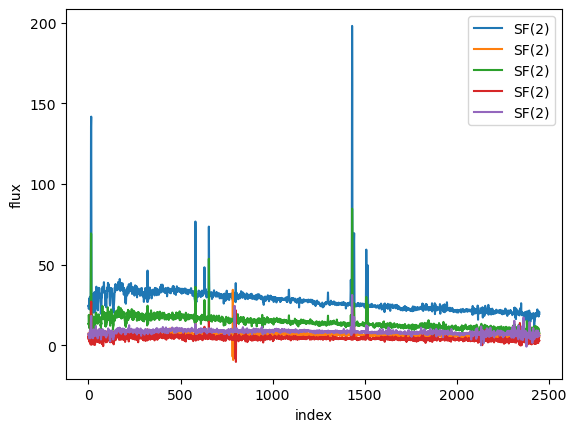

In [10]:
for i in range(5):
    plt.plot(data[i], label = labels[i]+'('+str(encoded_labels[i])+')')
plt.xlabel('index')
plt.ylabel('flux')
plt.legend()
plt.show()

## Hold-out approach (data splitting)

In [11]:
# we normalise the data
data_norm = np.array([d/1000 for d in data])
print(data_norm.shape)


# we split the data
X_train, X_test, y_train, y_test = train_test_split(
    data_norm, encoded_labels, test_size=0.2, random_state=42)

print(X_train.shape)

# We check the maximum value of the data
print(np.max(X_train))

(6092, 2450)
(4873, 2450)
1.82019


## Modelling

We can try to classify the spectra with an ```Adaboost``` classifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). 

AdaBoost, short for "Adaptive Boosting," is a popular ensemble learning technique used in machine learning. It works by combining multiple "weak learners" to create a single "strong learner." A weak learner is a simple model that performs slightly better than random guessing. AdaBoost turns these weak learners into a strong one through an iterative process. Here's a brief overview of how it works:

1. **Initialization**: AdaBoost starts by assigning equal weights to all samples in the training dataset. These weights represent the importance of each sample in constructing the learners.

2. **Training Weak Learners**: In each iteration, a weak learner is trained on the dataset. This learner is typically a simple model like a decision stump (a one-level decision tree).

3. **Error Calculation**: After training a weak learner, AdaBoost calculates its error rate, which is the weighted sum of the misclassifications made by the learner.

4. **Update Weights**: The weights of the training samples are then updated. Samples that were misclassified by the weak learner are given more weight, and samples that were correctly classified are given less weight. This ensures that in the next iteration, the new weak learner focuses more on the samples that were previously misclassified.

5. **Combine Learners**: Each weak learner is assigned a weight based on its accuracy. More accurate learners are given more weight. 

6. **Final Model**: The process repeats for a specified number of iterations or until a certain accuracy level is reached. The final model is a weighted combination of all the weak learners.

7. **Prediction**: To make predictions, AdaBoost combines the decisions of its weak learners based on their weights. The final output is the weighted vote of all the weak learners.

AdaBoost is powerful because it focuses on the difficult cases, ensuring that the ensemble model is robust and handles a variety of data points well. It's commonly used in classification problems and is known for its simplicity and effectiveness, especially when dealing with binary classification tasks.

In [12]:
clf = AdaBoostClassifier()
clf.fit(X_train,y_train)

AdaBoostClassifier()

In [13]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8802296964725185


In [14]:
confusion_matrix(y_test, y_pred)

array([[ 49,  36,   1],
       [ 13,  96,  45],
       [  2,  49, 928]])

In [19]:
report = classification_report(y_test, y_pred, output_dict=True)
dfreport = pd.DataFrame(report).transpose()
dfreport

# Support is the number of actual occurrences of the class in the specified dataset.

,precision,recall,f1-score,support
0,0.765625,0.569767,0.653333,86.00000
1,0.530387,0.623377,0.573134,154.00000
2,0.952772,0.947906,0.950333,979.00000
accuracy,0.880230,0.880230,0.880230,0.88023
macro avg,0.749595,0.713683,0.725600,1219.00000
weighted avg,0.886208,0.880230,0.881727,1219.00000


## Neural Network

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape = [2450]),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2024-01-07 16:42:59.828541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-07 16:42:59.828730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, epochs=200, validation_data= (X_test, y_test), verbose = 0)

2024-01-07 16:43:02.848671: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-07 16:43:03.077741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-07 16:43:09.081775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


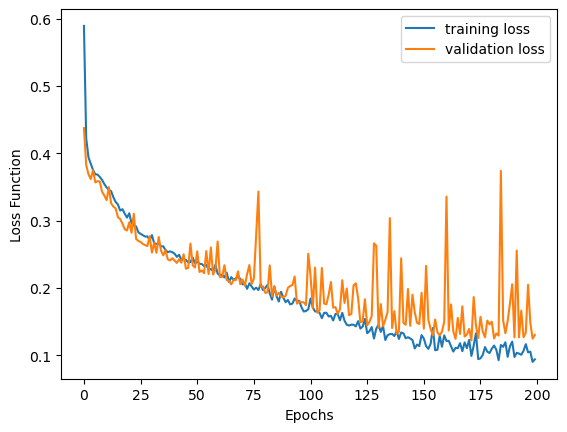

In [23]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

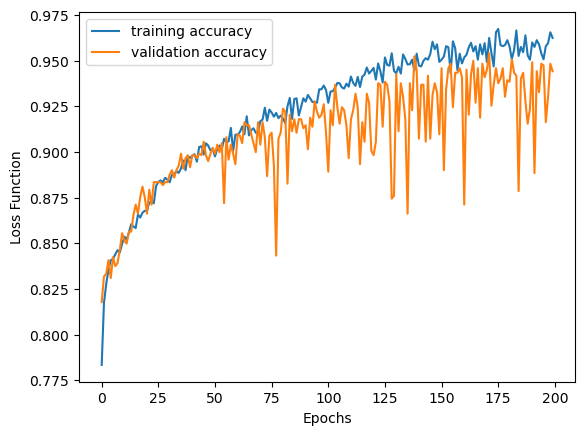

In [24]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [25]:
preds = np.argmax(model.predict(X_test), axis = 1)
confusion_matrix(y_test, preds)

2024-01-07 16:46:34.025542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 8ms/step


array([[ 62,  24,   0],
       [  2, 126,  26],
       [  0,  16, 963]])

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.9442165709598032


In [27]:
print(model.evaluate(X_test, y_test))
print(model.evaluate(X_train, y_train))

 1/39 [..............................] - ETA: 0s - loss: 0.0578 - accuracy: 1.0000

39/39 [==============================] - 0s 6ms/step - loss: 0.1305 - accuracy: 0.9442
[0.1305418163537979, 0.9442165493965149]
153/153 [==============================] - 1s 8ms/step - loss: 0.0767 - accuracy: 0.9739
[0.07670491933822632, 0.9739380478858948]


In [28]:
report = classification_report(y_test, preds, output_dict=True)
dfreport = pd.DataFrame(report).transpose()
dfreport

# Support is the number of actual occurrences of the class in the specified dataset.

,precision,recall,f1-score,support
0,0.968750,0.720930,0.826667,86.000000
1,0.759036,0.818182,0.787500,154.000000
2,0.973711,0.983657,0.978659,979.000000
accuracy,0.944217,0.944217,0.944217,0.944217
macro avg,0.900499,0.840923,0.864275,1219.000000
weighted avg,0.946240,0.944217,0.943786,1219.000000


## 1-D Convolutional Neural Network

In [33]:
# create model
model = tf.keras.Sequential()
model.add(layers.Conv1D(6, 15, activation = 'relu', input_shape = (2450,1))) # 2450 is the number of pixels in the spectra
model.add(layers.MaxPooling1D(pool_size = (2), strides = (2)))
model.add(layers.Conv1D(3, 15, strides = 1, activation = 'relu'))
model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))
# compile model
model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [34]:
# We need to add a "fake" dimension to the data (the channel)
# Remember that an image has normally 3 dimensions: x-resolution, y-resolution, channel (RGB for example)
# The np.newaxis is a quick way to add a new dimension to the array.
X_train_CNN = X_train[:,:, np.newaxis]
X_test_CNN = X_test[:,:, np.newaxis]

print(X_train.shape)
print(X_train_CNN.shape)

(4873, 2450)
(4873, 2450, 1)


In [35]:
history = model.fit(X_train_CNN, y_train, epochs=50, validation_data= (X_test_CNN, y_test), verbose = 0)

2024-01-07 17:01:25.259934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-07 17:01:31.058196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


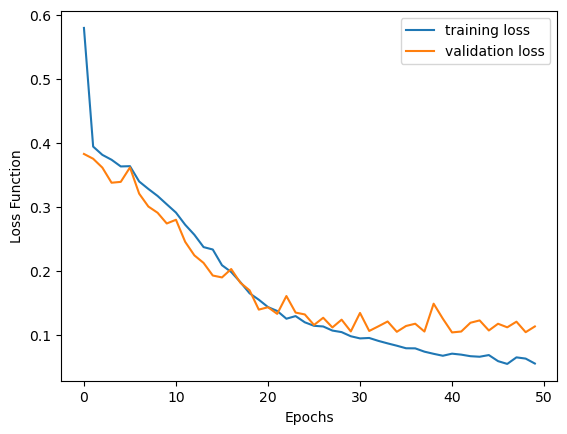

In [36]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

You should note how the CNN is much more efficient in learning (in terms of epochs, it only requires 50 epochs) when compared to the FFNN. 

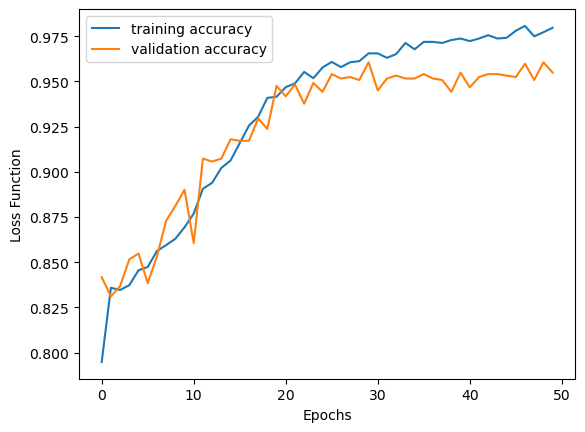

In [37]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [38]:
preds = np.argmax(model.predict(X_test), axis = 1)
confusion_matrix(y_test, preds)

2024-01-07 17:02:45.939007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 14ms/step


array([[ 66,  20,   0],
       [  1, 134,  19],
       [  0,  15, 964]])

In [39]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.9548810500410172


In [40]:
print(model.evaluate(X_test_CNN, y_test))
print(model.evaluate(X_train_CNN, y_train))

 1/39 [..............................] - ETA: 0s - loss: 0.0394 - accuracy: 0.9688

39/39 [==============================] - 0s 7ms/step - loss: 0.1139 - accuracy: 0.9549
[0.11389132589101791, 0.9548810720443726]
153/153 [==============================] - 2s 10ms/step - loss: 0.0556 - accuracy: 0.9797
[0.05562499538064003, 0.9796839952468872]


In [42]:
report = classification_report(y_test, preds, output_dict=True)
dfreport = pd.DataFrame(report).transpose()
dfreport

# Support is the number of actual occurrences of the class in the specified dataset.

,precision,recall,f1-score,support
0,0.985075,0.767442,0.862745,86.000000
1,0.792899,0.870130,0.829721,154.000000
2,0.980671,0.984678,0.982671,979.000000
accuracy,0.954881,0.954881,0.954881,0.954881
macro avg,0.919548,0.874083,0.891712,1219.000000
weighted avg,0.957260,0.954881,0.954887,1219.000000


# Oversampling

The dataset is unbalanced, so we can try some approaches to see if they help (they do not always do). Oversampling comes to mind.

In [43]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# We need to add a "fake" dimension to the data (the channel)
X_resampled_CNN = X_resampled[:,:, np.newaxis]

In [44]:
# create model
model = tf.keras.Sequential()
model.add(layers.Conv1D(6, 15, activation = 'relu', input_shape = (2450,1)))
model.add(layers.MaxPooling1D(pool_size = (2), strides = (2)))
model.add(layers.Conv1D(3, 15, strides = 1, activation = 'relu'))
model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))
# compile model
model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [45]:
history = model.fit(X_resampled_CNN, y_resampled, epochs=50, validation_data= (X_test_CNN, y_test), verbose = 0)

2024-01-07 17:03:47.794524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-07 17:03:54.664354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


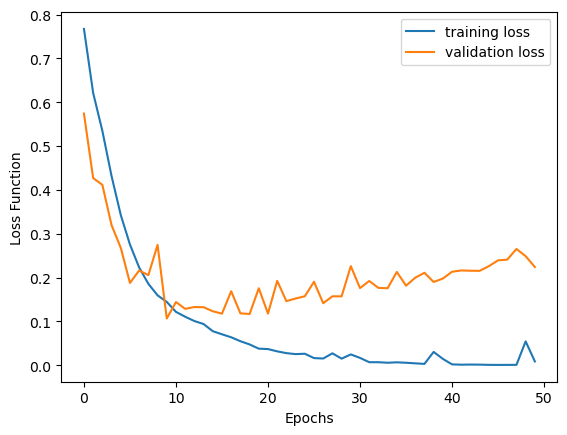

In [46]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

Note how with oversampling the loss function curve flattens out much earlier than without oversampling, pointing to a much quicker learning. But at the same time it shows a much more pronunced overfitting, since the network is too complex for this problem.

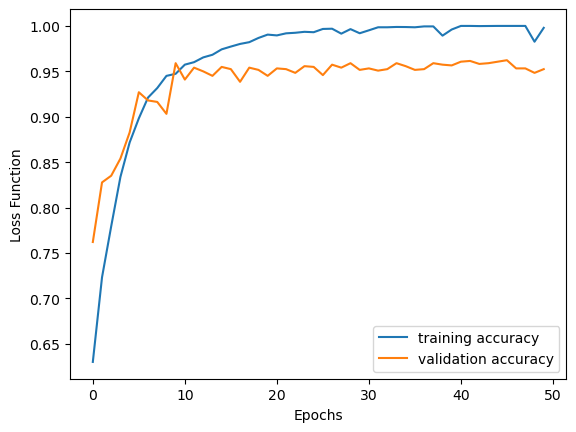

In [47]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [48]:
preds = np.argmax(model.predict(X_test), axis = 1)
confusion_matrix(y_test, preds)

2024-01-07 17:06:33.115270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 14ms/step


array([[ 76,  10,   0],
       [ 16, 129,   9],
       [  0,  23, 956]])

In [49]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.9524200164068909


In [50]:
print(model.evaluate(X_test_CNN, y_test))
print(model.evaluate(X_train_CNN, y_train))

39/39 [==============================] - 0s 6ms/step - loss: 0.2240 - accuracy: 0.9524
[0.2239540070295334, 0.9524199962615967]
153/153 [==============================] - 2s 10ms/step - loss: 0.0147 - accuracy: 0.9953
[0.014654668979346752, 0.9952800869941711]


Note how the accuracies reached are better with oversampling than without.

In [51]:
report = classification_report(y_test, preds, output_dict=True)
dfreport = pd.DataFrame(report).transpose()
dfreport

# Support is the number of actual occurrences of the class in the specified dataset.

,precision,recall,f1-score,support
0,0.826087,0.883721,0.853933,86.00000
1,0.796296,0.837662,0.816456,154.00000
2,0.990674,0.976507,0.983539,979.00000
accuracy,0.952420,0.952420,0.952420,0.95242
macro avg,0.871019,0.899297,0.884642,1219.00000
weighted avg,0.954506,0.952420,0.953287,1219.00000


In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2436, 6)           96        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1218, 6)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1204, 3)           273       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 602, 3)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1806)              0         
                                                                 
 dense_5 (Dense)             (None, 128)              

## CNN with regularisation and less filters

Since the overfitting is quite pronounced we can add some regularisation to the network in from of 50% dropout (with ```layers.Dropout(0.5)```) (see the code below for the network construction).

In [65]:
# create model
model = tf.keras.Sequential()
model.add(layers.Conv1D(3, 15, activation = 'relu', input_shape = (2450,1)))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size = (2), strides = (2)))
model.add(layers.Conv1D(2, 15, strides = 1, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size = 10, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'softmax'))
# compile model
model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [66]:
historyreg = model.fit(X_resampled_CNN, y_resampled, epochs=50, validation_data= (X_test_CNN, y_test), verbose = 0)

2024-01-07 17:16:39.383351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-07 17:16:48.958109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


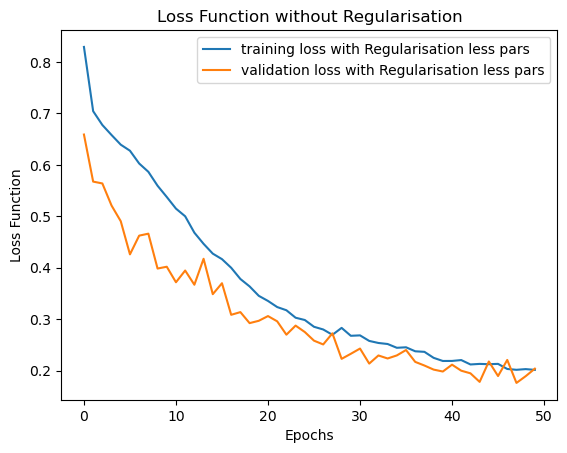

In [73]:
plt.plot(historyreg.history['loss'], label = 'training loss with Regularisation less pars')
plt.plot(historyreg.history['val_loss'], label = 'validation loss with Regularisation less pars')
#plt.plot(history.history['loss'], label = 'training loss without Regularisation')
#plt.plot(history.history['val_loss'], label = 'validation loss without Regularisation')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.title('Loss Function without Regularisation')
plt.show()

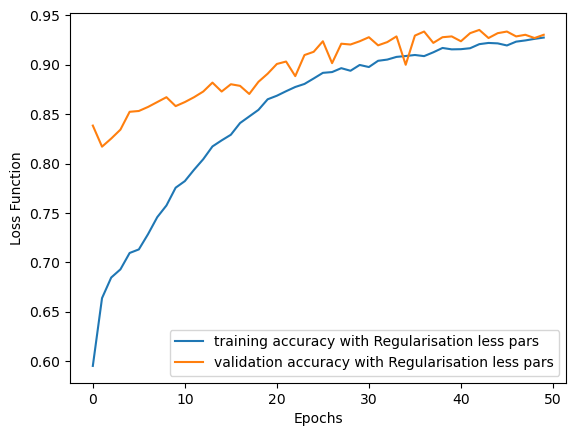

In [71]:
plt.plot(historyreg.history['accuracy'], label = 'training accuracy with Regularisation less pars')
plt.plot(historyreg.history['val_accuracy'], label = 'validation accuracy with Regularisation less pars')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [72]:
report = classification_report(y_test, preds, output_dict=True)
dfreport = pd.DataFrame(report).transpose()
dfreport

# Support is the number of actual occurrences of the class in the specified dataset.

,precision,recall,f1-score,support
0,0.826087,0.883721,0.853933,86.00000
1,0.796296,0.837662,0.816456,154.00000
2,0.990674,0.976507,0.983539,979.00000
accuracy,0.952420,0.952420,0.952420,0.95242
macro avg,0.871019,0.899297,0.884642,1219.00000
weighted avg,0.954506,0.952420,0.953287,1219.00000
